<a href="https://colab.research.google.com/github/supsi-dacd-isaac/TeachDecisionMakingUncertainty/blob/main/L05/CVaR_finance_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Portfolio Return and Loss Calculation for

https://blog.quantinsti.com/cvar-expected-shortfall/

This code analyzes the performance of a portfolio containing three assets:
* Amazon (AMZN), Tesla (TSLA), Apple (AAPL) from a 30-05-2023 to 30-01-2025.

#### Steps:

1. **Data Download**:  Using `yfinance`, the historical daily closing of AMZN, TSLA, and AAPL are downloaded for the specified period

2. **Data Preparation**: Combine into a single DataFrame `df`
   
3. **Return Calculation**: The daily returns for each stock are calculated using the percentage change in closing prices. The returns are then negated (indicated by `-pct_change()`), as the script aims to compute losses (negative returns).
   
$$
\text{Percentage Change} = \frac{\text{Current Value} - \text{Previous Value}}{\text{Previous Value}} \times 100
$$



4. **Portfolio Construction**: a weighted portfolio created using the returns of the individual stocks. Returns (`Rp`) are calculated as the weighted sum of individual stock returns.

5. **Portfolio Value**: An initial portfolio value of 1,000,000 is set (`W`), and the cumulative returns are used to compute the portfolio value over time. The value is updated daily by multiplying the initial value by the cumulative product of (1 + portfolio returns).
   
6. **Loss Calculation**: The losses are computed as the difference between the initial portfolio value and the current portfolio value for each day, stored in the `L` column.

#### Output:
- The final DataFrame `df` contains:
  - Portfolio values (`Portfolio`)
  - Daily losses (`L`)
  - The weighted portfolio return on each day (`Rp`)

This analysis allows tracking how a portfolio of these three assets performs over time and calculates the losses incurred compared to the initial portfolio value.


In [42]:
import numpy as np
import pandas as pd # library for data analysis
import yfinance as yf  # we will load the data from here
from scipy.stats import norm

# Download the data
amzn = yf.download('AMZN', '2023-05-30', '2025-01-30')
tsla = yf.download('TSLA', '2023-05-30', '2025-01-30')
aapl = yf.download('AAPL', '2023-05-30', '2025-01-30')

# Extract only closing prices
amzn_close = amzn['Close']
tsla_close = tsla['Close']
aapl_close = aapl['Close']

# Put all three closing prices together
df = pd.concat([amzn_close, tsla_close, aapl_close], axis=1)
df.columns = ['AMZN', 'TSLA', 'AAPL']

# Compute the returns
df['R1'] = -df['AMZN'].pct_change(fill_method=None)
df['R2'] = -df['TSLA'].pct_change(fill_method=None)
df['R3'] = -df['AAPL'].pct_change(fill_method=None)

df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AMZN,TSLA,AAPL,R1,R2,R3
Date,,,,,,
2023-05-30,121.660004,201.160004,175.772614,NaN,NaN,NaN
2023-05-31,120.580002,203.929993,175.723053,0.008877,-0.013770,0.000282
2023-06-01,122.769997,207.520004,178.538574,-0.018162,-0.017604,-0.016022
2023-06-02,124.250000,213.970001,179.391159,-0.012055,-0.031081,-0.004775
2023-06-05,125.300003,217.610001,178.032990,-0.008451,-0.017012,0.007571


In [43]:
# Construct the portfolio returns column as a weighted sum of individual asset returns and weights
w = np.array([0.4, 0.3, 0.3])
df['Rp'] = (df[['R1', 'R2', 'R3']] * w).sum(axis=1)
df = df.drop(df.index[0])

# Add the Portfolio column with an initial value of 1,000,000
W = 1000000
df['Portfolio'] = W * (1 + df['Rp']).cumprod()

# Compute losses and add as a column to df
df['L'] = W - df['Portfolio']
df.head()

,AMZN,TSLA,AAPL,R1,R2,R3,Rp,Portfolio,L
Date,,,,,,,,,
2023-05-31,120.580002,203.929993,175.723053,0.008877,-0.013770,0.000282,-0.000496,999504.449394,495.550606
2023-06-01,122.769997,207.520004,178.538574,-0.018162,-0.017604,-0.016022,-0.017353,982160.190702,17839.809298
2023-06-02,124.250000,213.970001,179.391159,-0.012055,-0.031081,-0.004775,-0.015579,966859.077840,33140.922160
2023-06-05,125.300003,217.610001,178.032990,-0.008451,-0.017012,0.007571,-0.006213,960852.454859,39147.545141
2023-06-06,126.610001,221.309998,177.666153,-0.010455,-0.017003,0.002060,-0.008665,952526.985019,47473.014981


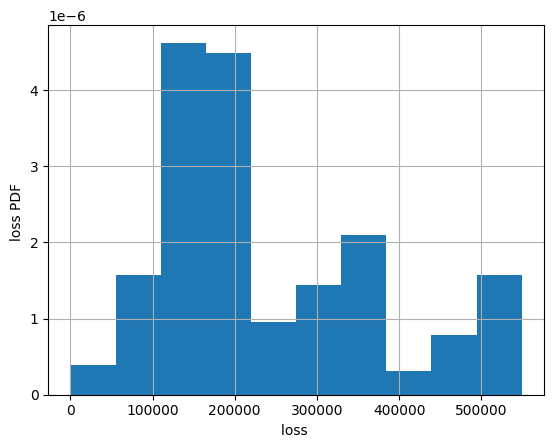

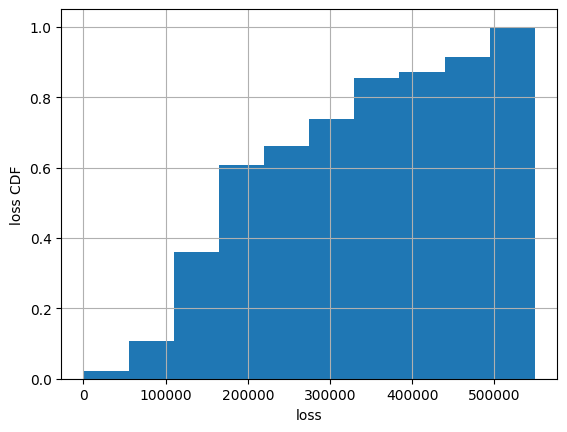

In [44]:
import matplotlib.pyplot as plt
df['L'].hist(density=True) # show pdf of daily losses
plt.xlabel('loss ')
plt.ylabel('loss PDF ')
plt.show()
df['L'].hist(density=True, cumulative=True) # show cdf of daily losses
plt.xlabel('loss')
plt.ylabel('loss CDF')
plt.show()

# Analytical vs empirical CVaR estimation

In [57]:
# Compute VaR(zero)
alpha = 0.01
VaR_zero = W - df['Portfolio'].quantile(alpha)
print('Expected Shortfall is: {:.2f}'.format(VaR_zero))


Expected Shortfall is: 531935.82


In [58]:
# Expected Shortfall analytical (assuming gaussian)
ES_analytic = df['L'].mean() + df['L'].std() * norm.pdf(norm.ppf(alpha)) / (1 - alpha)
print('Expected Shortfall (analytical) is: {:.2f}'.format(ES_analytic))

Expected Shortfall (analytical) is: 242572.93


In [59]:
# Expected Shortfall (Conditional Value at Risk)
ES_empirical = df.loc[df['L'] > VaR_zero, 'L'].mean()

print('Expected Shortfall (empirical) is: {:.2f}'.format(ES_empirical))

Expected Shortfall (empirical) is: 543014.15
